<h1> Regression </h1>

<hr>

<p> 
The present project attempts to predict the median price of homes in a given Boston suburb in the mid-1970s. 
</p>

<h2> The Dataset </h2>

<hr>

<p> The dataset has 506 data points, split between 404 training samples and 102 test samples, each with 13 numerical features. And each feature in the input data has a different scale. The targets are the median values of owner-occupied homes, in thousands of dollars. </p>
<p> This dataset comes packaged with Keras. </p>


In [1]:
from keras.datasets import boston_housing

(train_data, train_labels), (test_data, test_labels) = boston_housing.load_data()

57026/57026 [==============================] - 0s 0us/step


In [2]:
train_data.shape

(404, 13)

In [3]:
test_data.shape

(102, 13)

In [4]:
train_labels[:10]

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4])

<h2> Preparing the Data </h2>

<hr>

<p> It would be problematic to feed into a neural network values that all take wildly different ranges. The network might be able to automatically adapt to such heterogeneous data, but it would definitely make learning more difficult. A widespread best practice to deal with such data is to do feature-wise normalization: for each feature in the input data (a column in the input data matrix), you subtract the mean of the feature and divide by the standard deviation, so that the feature is centered around 0 and has a unit standard deviation. </p>
<p> Note that the quantities used for normalizing the test data are computed using the training data. You should never use in your workflow any quantity computed on the test data, even for something as simple as data normalization. </p>

In [5]:
mean = train_data.mean(axis=0)
mean

array([3.74511057e+00, 1.14801980e+01, 1.11044307e+01, 6.18811881e-02,
       5.57355941e-01, 6.26708168e+00, 6.90106436e+01, 3.74027079e+00,
       9.44059406e+00, 4.05898515e+02, 1.84759901e+01, 3.54783168e+02,
       1.27408168e+01])

In [6]:
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

In [7]:
test_data -= mean
test_data /= std

<h2> Building your network </h2>

<hr>

<p> In general, the less training data you have, the worse overfit- ting will be, and using a small network is one way to mitigate overfitting. </p>
<p> The network ends with a single unit and no activation (it will be a linear layer). This is a typical setup for scalar regression (a regression where you’re trying to predict a single continuous value). </p>
<p> Note that the model is compiled with the mse loss function—mean squared error, the square of the difference between the predictions and the targets. This is a widely used loss function for regression problems. </p>
<p> The monitored metric is the mean absolute error (MAE). It’s the absolute value of the difference between the predictions and the targets. </p>

In [8]:
from tensorflow.keras import Sequential, layers

In [9]:
def build_model():
  model = Sequential([
      layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(
      loss='mse',
      optimizer='adam',
      metrics=['mae']
  )

  return model

<h2> Validating </h2>

<hr>

<p> Because there are so few data points, the validation set would end up being very small (for instance, about 100 examples). As a consequence, the validation scores might change a lot depending on which data points you chose to use for validation and which you chose for training: the validation scores might have a high variance with regard to the validation split. </p>
<p> The best practice in such situations is to use K-fold cross-validation. It consists of splitting the available data into K partitions (typically K = 4 or 5), instanti- ating K identical models, and training each one on K – 1 partitions while evaluating on the remaining partition. The validation score for the model used is then the average of the K validation scores obtained. </p>

In [10]:
import numpy as np

k=4
num_val_samples = len(train_data) // k 
num_epochs = 100
all_scores = []

In [11]:
for i in range(k):
  print('processing fold #', i)
  val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples] 
  val_targets = train_labels[i * num_val_samples: (i + 1) * num_val_samples]

  partial_train_data = np.concatenate( 
    [train_data[:i * num_val_samples],
    train_data[(i + 1) * num_val_samples:]], axis=0)
  
  partial_train_targets = np.concatenate( 
    [train_labels[:i * num_val_samples],
    train_labels[(i + 1) * num_val_samples:]], axis=0)
  
  # Builds the Keras model (already compiled)
  model = build_model()

  # Trains the model (in silent mode, verbose = 0)
  model.fit(partial_train_data, 
            partial_train_targets,
            epochs=num_epochs, 
            batch_size=1, 
            verbose=0)
  
  # Evaluates the model on the validation data
  val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
  all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


<p> The different runs do indeed show rather different validation scores. </p>

In [12]:
all_scores

[2.069300889968872, 2.520738363265991, 2.594773054122925, 2.2500946521759033]

In [13]:
np.mean(all_scores)

2.358726739883423

In [16]:
num_epochs = 500
all_mae_histories = []

for i in range(k):
  print('processing fold #', i)
  val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples] 
  val_targets = train_labels[i * num_val_samples: (i + 1) * num_val_samples]

  partial_train_data = np.concatenate( 
    [train_data[:i * num_val_samples],
    train_data[(i + 1) * num_val_samples:]], axis=0)
  
  partial_train_targets = np.concatenate( 
    [train_labels[:i * num_val_samples],
    train_labels[(i + 1) * num_val_samples:]], axis=0)
  
  # Builds the Keras model (already compiled)
  model = build_model()

  # Trains the model (in silent mode, verbose = 0)
  history = model.fit(partial_train_data, 
            partial_train_targets,
            epochs=num_epochs, 
            batch_size=1, 
            verbose=0)
  
  mae_history = history.history['mae']
  all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


<h2> Building the history of successive mean K-fold validation scores </h2>

<hr>

In [17]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

<h2> Plotting the validation scores </h2>

<hr>

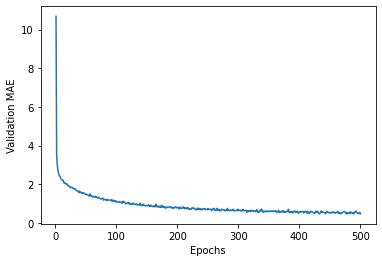

In [18]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

<p> It may be a little difficult to see the plot, due to scaling issues and relatively high vari- ance. Let’s do the following: </p>
  <ul>
    <li> Omit the first 10 data points, which are on a different scale than the rest of the curve. </li>
    <li> Replace each point with an exponential moving average of the previous points </li>
  </ul>
<p> To obtain a smooth curve. </p>

In [22]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

In [23]:
smooth_mae_history = smooth_curve(average_mae_history[10:])

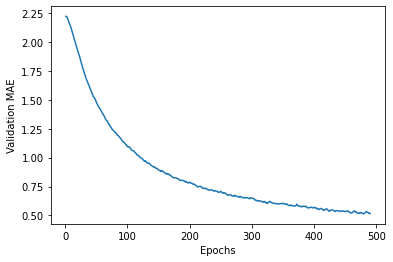

In [24]:
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

<p> According to this plot, validation MAE stops improving significantly after 80 epochs. Past that point, you start overfitting.
Once you’re finished tuning other parameters of the model (in addition to the number of epochs, you could also adjust the size of the hidden layers), you can train a final production model on all of the training data, with the best parameters, and then look at its performance on the test data. </p>

<h2> Training the final model </h2>

<hr>

In [25]:
model = build_model()

model.fit(train_data, 
          train_labels,
          epochs=80, 
          batch_size=16, 
          verbose=0)

test_mse_score, test_mae_score = model.evaluate(test_data, test_labels)

4/4 [==============================] - 0s 4ms/step - loss: 18.6479 - mae: 2.6796


In [26]:
test_mae_score

2.679565191268921

<hr>